In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [52]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data = data.drop(['Unnamed: 10'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Fuente(experimento)'] = data.index.astype(str) + '_' + data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Fuente','Experimento'], axis=1)
data.insert(0, 'T0', 0)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,0_Adsorcion de As+5 Espana ( 60ppmSb-As)
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,1_Adsorcion de As+5 Espana ( 60ppmAs-As)
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,2_Adsorcion de As+5 Espana ( 90ppmAs-As)
3,0,1.145313,1.696100,2.264219,3.106472,3.699600,4.016499,4.056284,4.106165,3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,9_Adsorcion de Sb Espana ( 120ppmSb-Sb)


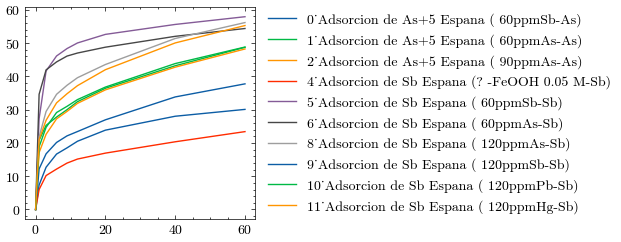

In [53]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [54]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [55]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [56]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




In [ ]:
from IPython.display import clear_output

class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []
        self.lattices = []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            p = self.processes["diffusion"]
            E_diff = p["e_diff"] + p.get("e_int_diff", 0) * n_ij
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Energía
    # ===================

    def calculate_total_energy(self):
        total_energy = 0
        for i in range(self.lattice.size):
            for j in range(self.lattice.size):
                if self.lattice.lattice[i, j] == 1:
                    n_ij = self.count_occupied_neighbors((i, j))
                    e_ads = self.processes["adsorption"]["e_ads"]
                    e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                    total_energy += e_ads + e_int_abs * n_ij
        return total_energy

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            # print(f"\rtime: {self.time:.4f}, delta_t: {delta_t:.4e}", end="")
            # time.sleep(0.00000005)

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.energies.append(self.calculate_total_energy())
                self.lattices.append(self.lattice.lattice.copy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


In [58]:
class KMCModelOptimizer:
    def __init__(self, exp_data, param_ranges, lattice_class, n_calls=200, n_simulations_avg=5):
        self.exp_data = np.array(exp_data)
        self.param_ranges = param_ranges
        self.lattice_class = lattice_class
        self.n_calls = n_calls
        self.n_simulations_avg = n_simulations_avg
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = None
        self.time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])  # o parametrizable

        if len(self.exp_data) != len(self.time_array):
            raise ValueError("La longitud de exp_data debe coincidir con la longitud de time_array.")

    def loss_function(self, params):
        param_dict = {name: val for name, val in zip(self.param_ranges.keys(), params)}

        processes = {}
        if 'e_ads' in param_dict:
            processes["adsorption"] = {
                "e_ads": param_dict["e_ads"],
                "e_int_abs": param_dict.get("e_int_abs", 0)
            }
        if 'e_des' in param_dict:
            processes["desorption"] = {
                "e_des": param_dict["e_des"],
                "e_int_des": param_dict.get("e_int_des", 0)
            }
        if 'e_diff' in param_dict:
            processes["diffusion"] = {
                "e_diff": param_dict['e_diff'],
                "e_int_diff": param_dict.get('e_int_diff', 0)
            }

        all_simulated_occupancies = []

        for _ in range(self.n_simulations_avg):
            lattice = self.lattice_class(int(param_dict['lattice_size']))
            kmc_model = KineticMonteCarlo(
                lattice=lattice,
                T=param_dict['T'],
                processes=processes,
                time_array=self.time_array
            )
            kmc_model.run_simulation()
            simulated_run_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
            all_simulated_occupancies.append(simulated_run_data)

        if not all_simulated_occupancies:
            return float('inf')

        avg_simulated_data = np.mean(all_simulated_occupancies, axis=0)
        error = np.mean((avg_simulated_data - self.exp_data) ** 2)

        if error < self.best_error:
            self.best_error = error
            self.best_params = param_dict

        if self.progress_bar:
            self.progress_bar.set_postfix({
                "Mejor error": f"{self.best_error:.6f}",
                "Progreso": f"{self.progress_bar.n}/{self.progress_bar.total}"
            })
            self.progress_bar.update(1)

        return error

    def optimize(self):
        self.progress_bar = tqdm(
            total=self.n_calls,
            desc="🚀 Optimización Bayesiana",
            position=0,
            ncols=100,
            unit="eval"
        )

        space = []
        for param_name, prange in self.param_ranges.items():
            if param_name == 'lattice_size':
                space.append(Integer(prange[0], prange[1], name=param_name))
            else:
                space.append(Real(prange[0], prange[1], name=param_name))

        start_time = time.time()

        result = gp_minimize(
            func=self.loss_function,
            dimensions=space,
            n_calls=self.n_calls,
            random_state=42
        )
        self.progress_bar.close()

        end_time = time.time()
        print("\n✅ Optimización completada")
        if self.best_params:
            print("🔹 Parámetros óptimos encontrados:", self.best_params)
            print(f"🔹 Error mínimo (MSE) encontrado: {self.best_error:.6f}")
        else:
            print("⚠️ No se encontraron parámetros óptimos.")
            print("   Últimos parámetros:", {s.name: v for s, v in zip(space, result.x)})
            print(f"   Último error: {result.fun:.6f}")

        print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")
        self.run_kmc_with_best_params()

    def run_kmc_with_best_params(self):
        if not self.best_params:
            print("ℹ️ No se encontraron parámetros óptimos para ejecutar el modelo final.")
            return

        processes = {}
        if 'e_ads' in self.best_params:
            processes["adsorption"] = {
                "e_ads": self.best_params["e_ads"],
                "e_int_abs": self.best_params.get("e_int_abs", 0)
            }
        if 'e_des' in self.best_params:
            processes["desorption"] = {
                "e_des": self.best_params["e_des"],
                "e_int_des": self.best_params.get("e_int_des", 0)
            }
        if 'e_diff' in self.best_params:
            processes["diffusion"] = {
                "e_diff": self.best_params["e_diff"],
                "e_int_diff": self.best_params.get("e_int_diff", 0)
            }


        print(f"\n⚙️ Ejecutando simulación final con los mejores parámetros: {self.best_params}")
        lattice = self.lattice_class(int(self.best_params['lattice_size']))
        kmc_model = KineticMonteCarlo(
            lattice=lattice,
            T=self.best_params['T'],
            processes=processes,
            time_array=self.time_array
        )
        kmc_model.run_simulation()

        simulated_final_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
        print("📊 Datos experimentales:", self.exp_data)
        print("📈 Datos simulados:", simulated_final_data)
        final_error = np.mean((simulated_final_data - self.exp_data) ** 2)
        print(f" MSE final (verificación): {final_error:.6f}")

Ocupación final: 53.29632653061225
Energía final: 15703.566401432334
Mean Squared Error (MSE): 8.746424126741278
{'adsorption': 452419, 'desorption': 51065, 'diffusion': 2191914}


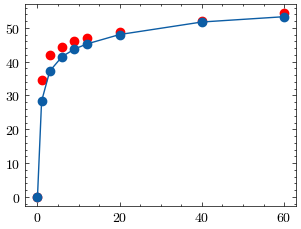

/Users/gtorres/Desktop/proyecto/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 225 (\N{LATIN SMALL LETTER A WITH ACUTE}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


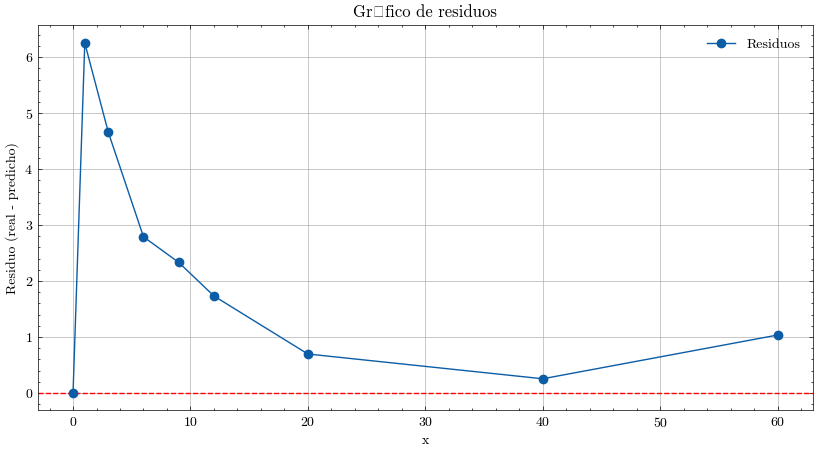

In [59]:

processes = {
    "adsorption": {"e_ads": 0.001078772689028137, "e_int_abs": 0.086237508219947825},
    "desorption": {"e_des": 0.250391868734861, "e_int_des": -0.01502},
    "diffusion": {"e_diff": 0.2138540925587024, "e_int_diff": -0.03553798527362284}
}
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 350

# Elegí la red: Square o Hexagonal
lattice = HexagonalLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())


simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.scatter(time_array, data.iloc[6, :9].to_numpy(),color = 'red', label='Experimental data')
mse = np.mean((data.iloc[6, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
print(kmc.events_count)

# Cálculo de residuos
residuos = data.iloc[6, :9].to_numpy() - np.array(list(simulated_data)) 

# Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.plot(time_array, residuos, marker='o', linestyle='-', label='Residuos')
plt.title('Gráfico de residuos')
plt.xlabel('x')
plt.ylabel('Residuo (real - predicho)')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Definir la variabilidad porcentual (por ejemplo, ±20%)
variabilidad = 0.1

# Crear un diccionario con los rangos para cada parámetro de processes
param_ranges = {}

for proc, params in processes.items():
    for key, val in params.items():
        if isinstance(val, (int, float, np.floating)):
            # Calcula los valores mínimo y máximo con variabilidad
            min_val = val * (1 - variabilidad)
            max_val = val * (1 + variabilidad)

            # Asegura que el rango esté ordenado de menor a mayor
            param_ranges[key] = sorted([min_val, max_val])

            # Agregar el rango para T (temperatura)
            param_ranges['T'] = [300,301]

            # Agregar el rango para lattice_size (tamaño de la red)
            param_ranges['lattice_size'] = [int(lattice_size * (1 - variabilidad)), int(lattice_size * (1 + variabilidad))]
# Mostrar los rangos generados
print(param_ranges)

{'e_ads': [0.0009708954201253234, 0.0011866499579309508], 'T': [300, 301], 'lattice_size': [315, 385], 'e_int_abs': [0.07761375739795305, 0.09486125904194262], 'e_des': [0.22535268186137491, 0.27543105560834713], 'e_int_des': [-0.016522000000000002, -0.013518], 'e_diff': [0.19246868330283218, 0.23523950181457268], 'e_int_diff': [-0.03909178380098513, -0.03198418674626056]}


In [61]:
# Selecciona los datos experimentales del experimento i
exp_data = data.iloc[6, :9].to_numpy()

# Usa los rangos de parámetros ya definidos en param_ranges y la clase HexagonalLattice
optimizer = KMCModelOptimizer(
    exp_data=exp_data,
    param_ranges=param_ranges,
    lattice_class=HexagonalLattice,
    n_calls=100,           # Puedes ajustar el número de llamadas según tu tiempo disponible
    n_simulations_avg=1   # Puedes aumentar para mayor robustez, pero será más lento
)

optimizer.optimize()


🚀 Optimización Bayesiana:   0%|                                          | 0/100 [00:00<?, ?eval/s]

KeyboardInterrupt: 

In [62]:
resultados_opt = pd.read_csv('resultados_optimizacion.csv')
resultados_opt

,experiment_index,best_error,e_ads,e_int_abs,e_des,e_int_des,e_diff,e_int_diff,lattice_size,T
0,0,0.102170,0.081506,0.042231,0.272000,0.068302,0.160000,0.160000,765,300.652977
1,1,1.915544,0.040199,0.042529,0.272000,0.068000,0.640000,0.108811,600,300.000000
2,2,0.661106,0.047140,0.038715,0.243444,0.267271,0.586739,0.150995,737,300.008465
3,3,0.037399,0.115559,0.077452,0.099043,0.166115,0.160000,0.118336,783,300.000000
4,4,0.109109,0.087042,0.051374,0.147142,0.149227,0.593463,0.085338,658,300.623917
5,5,3.198456,0.034788,0.035238,0.250392,-0.027200,NaN,NaN,600,300.525227
6,6,39.797460,0.001187,0.081499,0.234875,-0.015344,0.211515,-0.039092,315,300.025359
7,7,5.697875,0.039200,0.032803,0.272000,0.148845,0.206789,0.160000,600,300.198780
8,8,0.843838,0.039200,0.035252,0.272000,0.272000,0.640000,0.068713,727,300.644217
9,9,0.596735,0.080085,0.040421,0.272000,0.111082,0.187424,0.160000,600,300.358782


In [63]:
# Extraer cada columna de resultados_opt como listas
best_error = resultados_opt['best_error'].tolist()
e_ads = resultados_opt['e_ads'].tolist()
e_int_abs = resultados_opt['e_int_abs'].tolist()
e_des = resultados_opt['e_des'].tolist()
e_int_des = resultados_opt['e_int_des'].tolist()
e_diff = resultados_opt['e_diff'].tolist()
e_int_diff = resultados_opt['e_int_diff'].tolist()
lattice_size_opt = resultados_opt['lattice_size'].tolist()
T_opt = resultados_opt['T'].tolist()



In [64]:
e_diff

[0.16,
 0.6400000000000001,
 0.5867385173417683,
 0.16,
 0.5934632807795039,
 nan,
 0.2115146611413667,
 0.2067893372770648,
 0.6400000000000001,
 0.1874243043104213,
 0.6097390484280805,
 0.2032743983512453]

Mean Squared Error (MSE): 0.29355880005274304
{'adsorption': 211887, 'desorption': 64, 'diffusion': 4069}


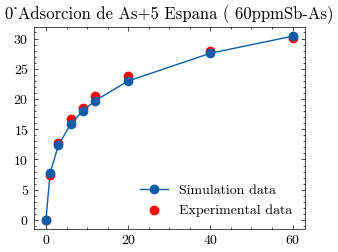

Mean Squared Error (MSE): 2.366015909574133
{'adsorption': 228706, 'desorption': 15, 'diffusion': 0}


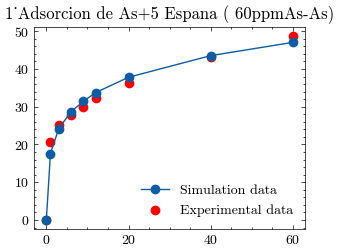

Mean Squared Error (MSE): 0.6588014731158981
{'adsorption': 340946, 'desorption': 51, 'diffusion': 0}


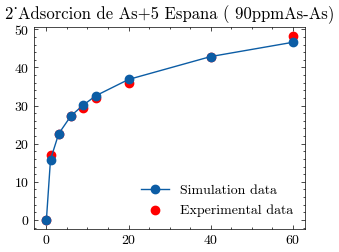

Mean Squared Error (MSE): 0.09582456517517242
{'adsorption': 30701, 'desorption': 42056, 'diffusion': 4278}


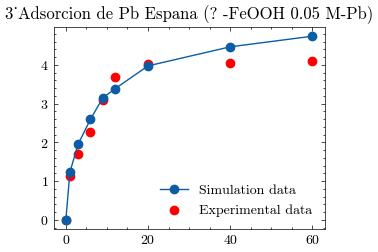

Mean Squared Error (MSE): 0.22901409657417635
{'adsorption': 109791, 'desorption': 5454, 'diffusion': 0}


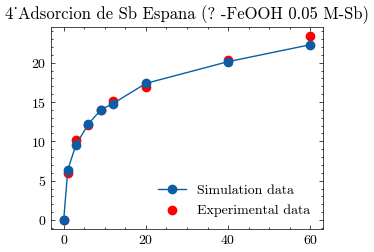

Mean Squared Error (MSE): 3.0601456871616968
{'adsorption': 981238, 'desorption': 595157}


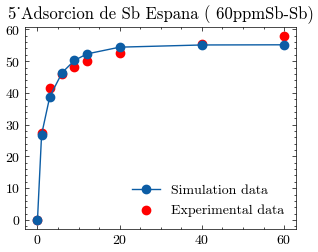

Mean Squared Error (MSE): 1.1070215029493953
{'adsorption': 615012, 'desorption': 93442, 'diffusion': 3491453}


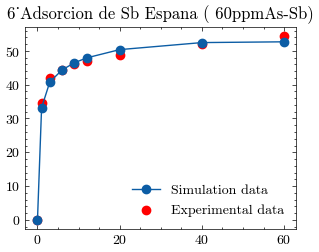

Mean Squared Error (MSE): 6.335334479330514
{'adsorption': 376346, 'desorption': 7, 'diffusion': 79}


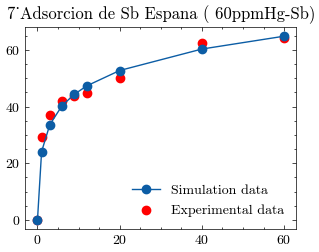

Mean Squared Error (MSE): 1.0290573126349456
{'adsorption': 434786, 'desorption': 22, 'diffusion': 0}


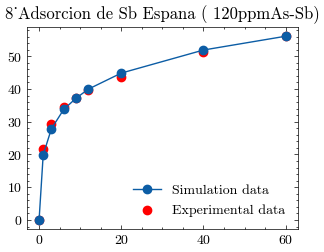

Mean Squared Error (MSE): 0.7983633280856696
{'adsorption': 165611, 'desorption': 41, 'diffusion': 925}


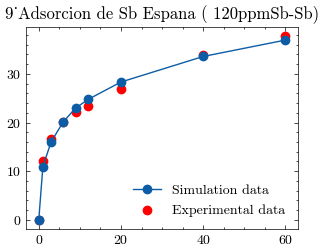

Mean Squared Error (MSE): 0.6633639459296808
{'adsorption': 252527, 'desorption': 17, 'diffusion': 0}


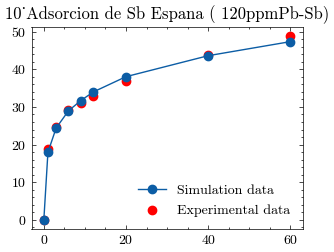

Mean Squared Error (MSE): 1.0440162485605717
{'adsorption': 410162, 'desorption': 36, 'diffusion': 166}


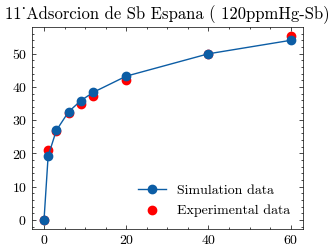

In [ ]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
errors_kmc = []

for i in range(len(resultados_opt)):

    processes = {
        "adsorption": {"e_ads": e_ads[i], "e_int_abs": e_int_abs[i]},
        "desorption": {"e_des": e_des[i], "e_int_des": e_int_des[i]},
        "diffusion": {"e_diff": e_diff[i], "e_int_diff": e_int_diff[i]}
    }
    # Elimina parámetros NaN de processes
    for proc in list(processes.keys()):
        for param in list(processes[proc].keys()):
            if np.isnan(processes[proc][param]):
                del processes[proc][param]
        # Si el proceso queda vacío, elimínalo también
        if not processes[proc]:
            del processes[proc]

    T = T_opt[i]
    lattice_size = lattice_size_opt[i]


    lattice = HexagonalLattice(size=lattice_size) 


    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()


    simulated_data = occupancy.values()
    plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
    plt.scatter(time_array, data.iloc[i, :9].to_numpy(),color = 'red', label='Experimental data')
    mse = np.mean((data.iloc[i, :9].to_numpy() - np.array(list(simulated_data))) ** 2)

    errors_kmc.append(mse)
    print(f"Mean Squared Error (MSE): {mse}")
    print(kmc.events_count)
    plt.title(data.iloc[i]['Fuente(experimento)'])
    plt.legend()
    plt.show()

Experimento: 0_Adsorcion de As+5 Espana ( 60ppmSb-As)
  q_e = 31.2199 mg/g, k_n = 0.0381 1/min, n = 2.3974
  Error cuadrático medio (MSE): 0.0972


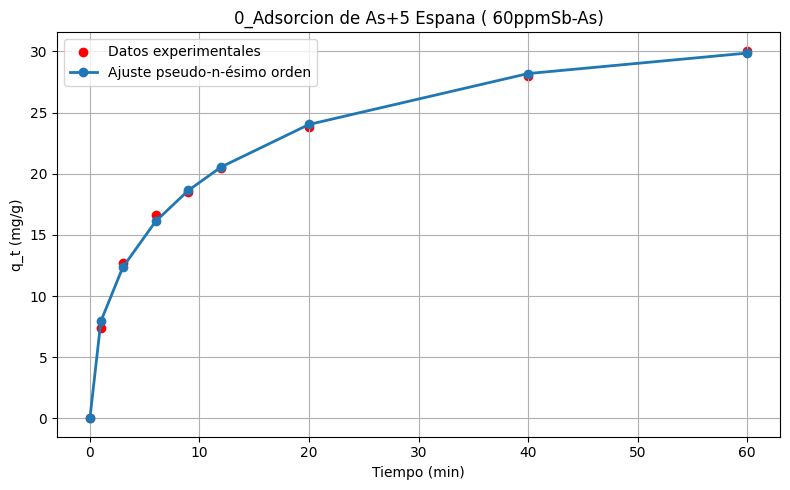

Experimento: 1_Adsorcion de As+5 Espana ( 60ppmAs-As)
  q_e = 252.5199 mg/g, k_n = 0.0000 1/min, n = 4.5234
  Error cuadrático medio (MSE): 0.9132


/var/folders/0j/wjdr50f52rs1fylv6znxjsbm0000gn/T/ipykernel_70920/3226252384.py:4: RuntimeWarning: invalid value encountered in power
  return q_e * (1 - np.exp(-k_n * t)) ** (1 / n)


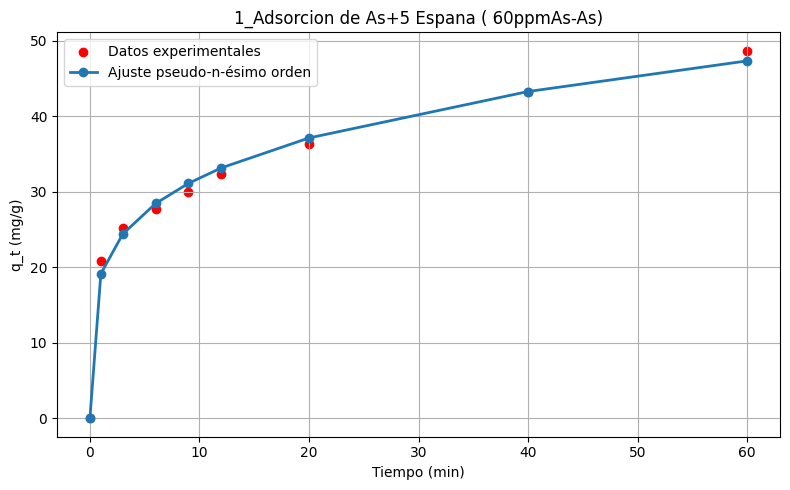

Error en el ajuste para el experimento 2: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Experimento: 3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
  q_e = 4.1684 mg/g, k_n = 0.1182 1/min, n = 1.4307
  Error cuadrático medio (MSE): 0.0308


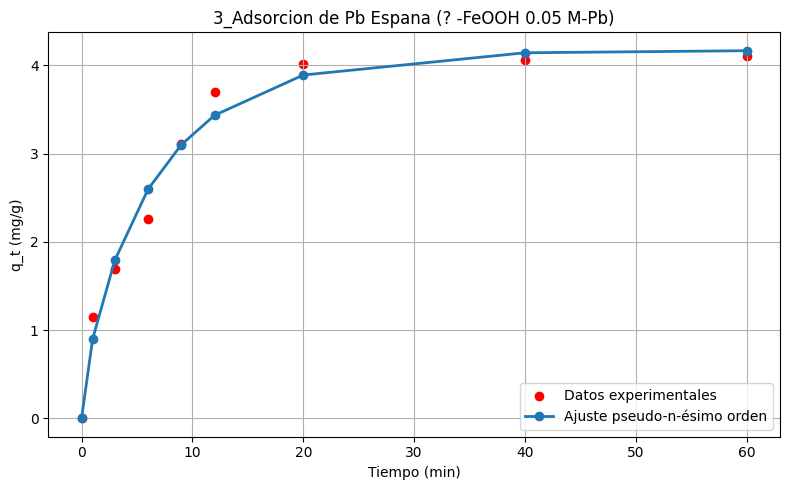

Experimento: 4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
  q_e = 28.6621 mg/g, k_n = 0.0118 1/min, n = 3.0845
  Error cuadrático medio (MSE): 0.1838


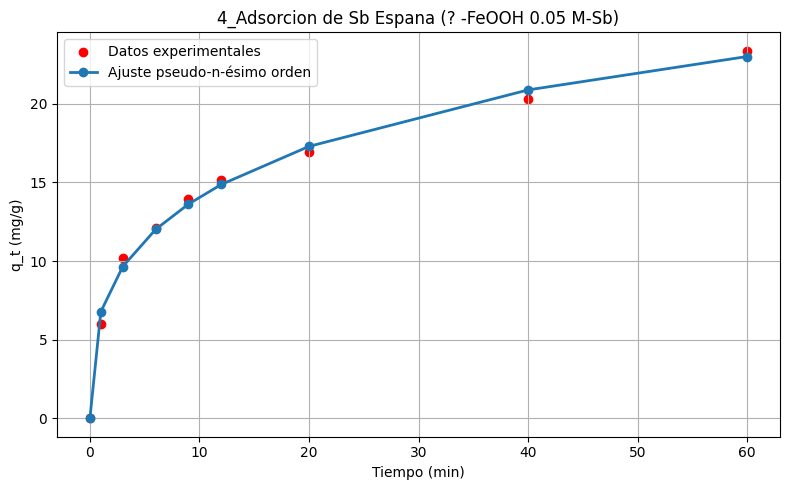

Experimento: 5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
  q_e = 56.2265 mg/g, k_n = 0.1033 1/min, n = 3.5471
  Error cuadrático medio (MSE): 2.1788


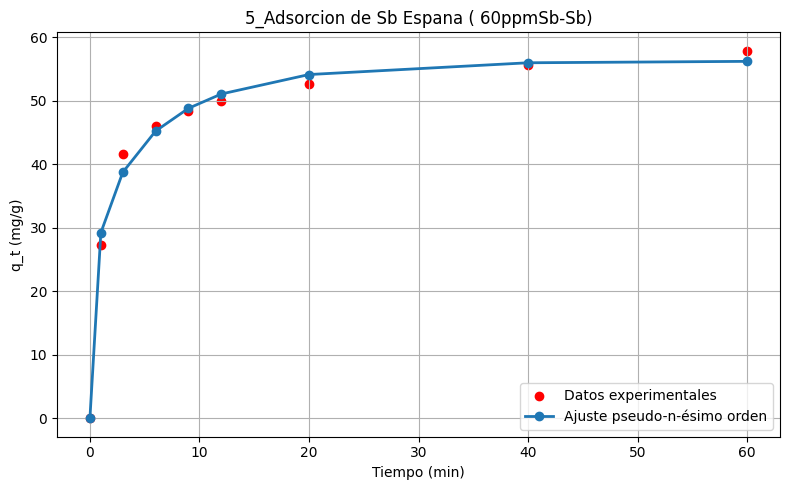

Experimento: 6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
  q_e = 55.3857 mg/g, k_n = 0.0251 1/min, n = 8.4136
  Error cuadrático medio (MSE): 0.5223


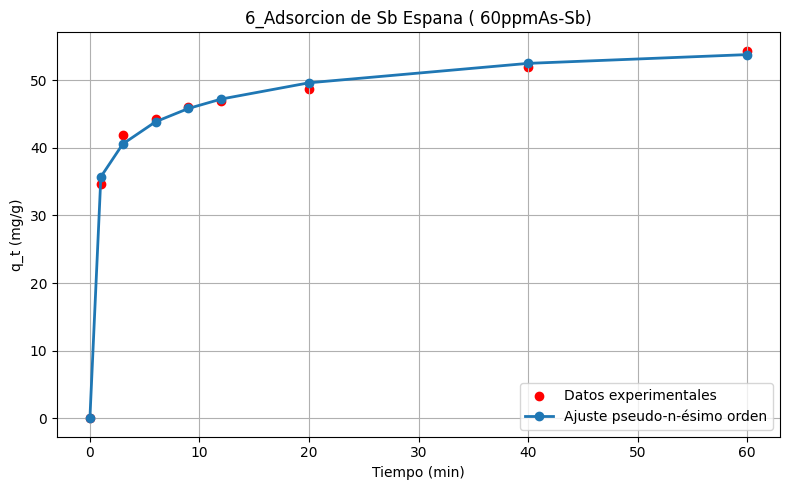

Experimento: 7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
  q_e = 286.8263 mg/g, k_n = 0.0000 1/min, n = 5.0747
  Error cuadrático medio (MSE): 2.1153


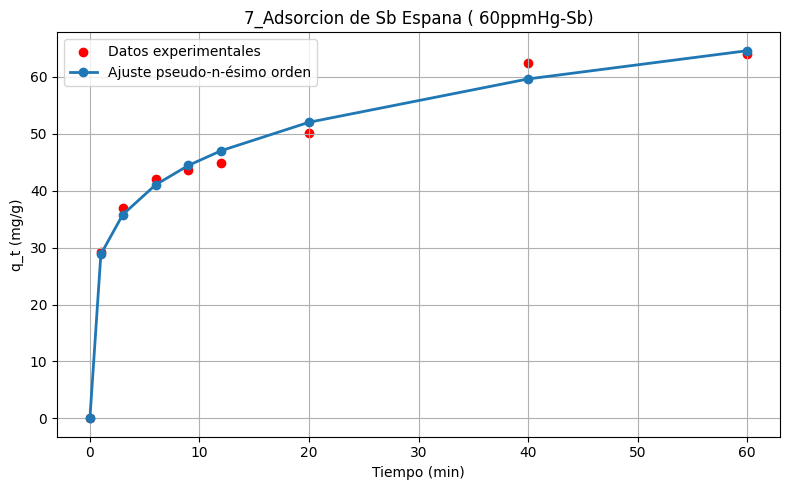

Experimento: 8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
  q_e = 80.8280 mg/g, k_n = 0.0037 1/min, n = 4.3975
  Error cuadrático medio (MSE): 0.2168


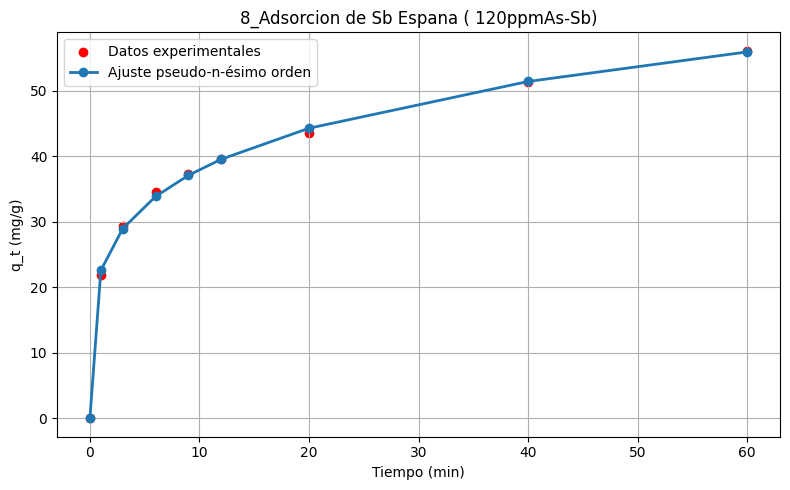

Experimento: 9_Adsorcion de Sb Espana ( 120ppmSb-Sb)
  q_e = 307.9274 mg/g, k_n = 0.0000 1/min, n = 3.6064
  Error cuadrático medio (MSE): 0.1414


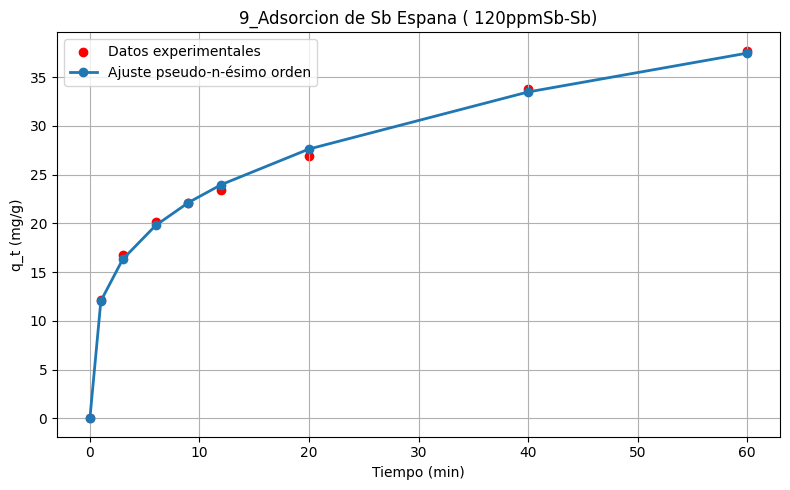

Error en el ajuste para el experimento 10: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Experimento: 11_Adsorcion de Sb Espana ( 120ppmHg-Sb)
  q_e = 325.0903 mg/g, k_n = 0.0000 1/min, n = 4.1821
  Error cuadrático medio (MSE): 0.0510


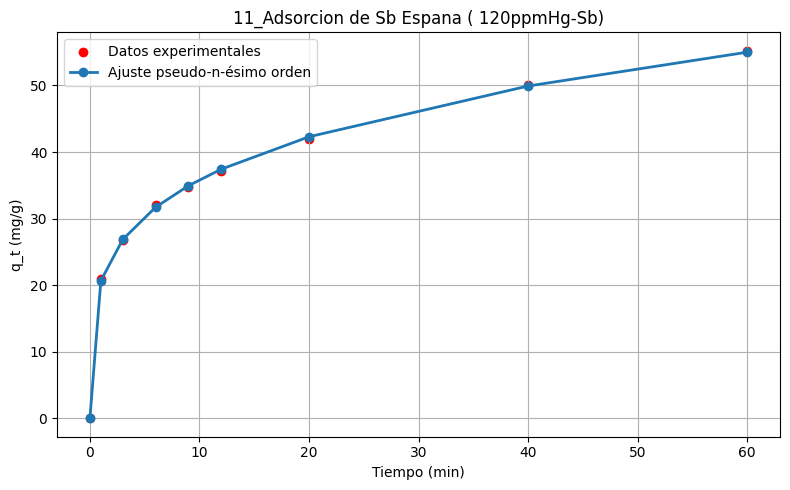

In [17]:
from scipy.optimize import curve_fit

def pseudo_n_order(t, q_e, k_n, n):
    return q_e * (1 - np.exp(-k_n * t)) ** (1 / n)

errors_curvefit = []

for i in range(len(data)):
    t_exp = time_array
    qt_exp = data.iloc[i, :9].to_numpy()

    # Ajuste de los datos experimentales al modelo pseudo-n-ésimo orden
    p0 = [max(qt_exp), 0.1, 2]
    try:
        params_opt, _ = curve_fit(pseudo_n_order, t_exp, qt_exp, p0=p0)
        q_e_fit, k_n_fit, n_fit = params_opt
        qt_fit = pseudo_n_order(t_exp, q_e_fit, k_n_fit, n_fit)

        print(f"Experimento: {data.iloc[i]['Fuente(experimento)']}")
        print(f"  q_e = {q_e_fit:.4f} mg/g, k_n = {k_n_fit:.4f} 1/min, n = {n_fit:.4f}")
        mse = np.mean((qt_exp - qt_fit) ** 2)
        print(f"  Error cuadrático medio (MSE): {mse:.4f}")
        errors_curvefit.append(mse)
        plt.figure(figsize=(8, 5))
        plt.scatter(t_exp, qt_exp, color='red', label='Datos experimentales')
        plt.plot(t_exp, qt_fit, marker='o', label='Ajuste pseudo-n-ésimo orden', linewidth=2)
        plt.title(data.iloc[i]['Fuente(experimento)'])
        plt.xlabel('Tiempo (min)')
        plt.ylabel('q_t (mg/g)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error en el ajuste para el experimento {i}: {e}")
        errors_curvefit.append('no se pudo ajustar')




In [19]:
# Crear un DataFrame con los errores de KMC y curve fit
errores_df = pd.DataFrame({
    'error_kmc': errors_kmc[:len(errors_curvefit)],
    'error_curvefit': errors_curvefit
})
errores_df

,error_kmc,error_curvefit
0,0.282416,0.097221
1,2.563171,0.913245
2,0.867038,no se pudo ajustar
3,0.252858,0.030787
4,0.287041,0.183768
5,3.198456,2.17882
6,40.399611,0.522286
7,6.090641,2.115285
8,1.018024,0.216812
9,0.581916,0.141395
